In [1]:
!jupyter nbextension enable --py --sys-prefix qgrid
!jupyter nbextension enable --py --sys-prefix widgetsnbextension 

Enabling notebook extension qgrid/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import openreview
from collections import Counter, defaultdict as dd
import numpy as np
import pandas as pd
import qgrid
from pprint import pprint
import datetime
import pickle
import re 
import time
import jellyfish
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20,8.27)}, font_scale=2)

In [4]:
def all_papers():
    client = openreview.Client(baseurl='https://openreview.net')
    paper_iterator = openreview.tools.iterget_notes(client, invitation='ICLR.cc/2019/Conference/-/Blind_Submission')
    return list(paper_iterator)

In [5]:
def ratings_and_confidence():
    client = openreview.Client(baseurl='https://openreview.net')
    review_iterator = openreview.tools.iterget_notes(client, invitation='ICLR.cc/2019/Conference/-/Paper.*/Official_Review')
    ratings = dd(list)
    confidence = dd(list)
    for review in review_iterator:
        ratings[review.forum].append(int(re.findall(pattern='\d+', string=review.content['rating'])[0]))
        confidence[review.forum].append(int(re.findall(pattern='\d+', string=review.content['confidence'])[0]))
    return ratings, confidence

In [6]:
papers = all_papers()
ratings, confidence = ratings_and_confidence()

In [7]:
def add_ratings(papers, ratings, confidence):
    for ix in range(len(papers)):
        forum = papers[ix].forum
        papers[ix].ratings = ratings.get(forum, [])
        papers[ix].confidence = confidence.get(forum, [])

In [8]:
add_ratings(papers, ratings, confidence)

In [9]:
def get_keywords(papers):
    return list(set([word.strip().lower() for p in papers for word in p.content['keywords']]))

def get_similarity(keywords):
    sim = dict()
    N = len(keywords)
    for i in range(N-1):
        for j in range(i+1, N):
            topic1 = keywords[i]
            topic2 = keywords[j]
            dist = len(set(topic1).intersection(set(topic2)))/len(set(max([topic1, topic2], key=lambda v: len(v))))
            if topic1 != topic2 and dist >= 0.70:
                dist = jellyfish.levenshtein_distance(topic1, topic2)
                sim[topic1, topic2] = dist
    return sim

def get_top_matches(sim):
    matches = dd(list)
    for pair in sim:
        if sim[pair] == 1:
            matches[pair[0]].append(pair[1])
            matches[pair[1]].append(pair[0])
    return matches    

In [10]:
keywords = get_keywords(papers)
start = time.time()
sim = get_similarity(keywords) # this may take several minutes 
finish = time.time()
print('Similarity computed in {:.2f} sec'.format(finish - start))

Similarity computed in 11.83 sec


In [11]:
matches = get_top_matches(sim)

In [12]:
def get_clusters(matches):
    clusters = dict()
    for topic in matches:
        values = matches[topic]
        clusters[topic] = topic
        for v in values:
            if len(matches.get(v, [])) > len(values) or \
            (len(matches.get(v, [])) == len(values) and topic > v):
                clusters[topic] = v
    # second pass 
    main = set(clusters.items())
    for topic in clusters:
        if topic not in main:
            clusters[topic] = clusters[clusters[topic]]
    return clusters

In [13]:
clusters = get_clusters(matches)
clusters.update({topic: 'generative adversarial networks' for topic in clusters if clusters[topic] == 'gan'})

In [14]:
def get_df(papers, clusters):
    rows = []
    for paper in papers:
        topic = paper.content['keywords'][0] if len(paper.content['keywords']) else ''
        cluster = clusters.get(topic.lower(), topic.lower() if topic else None)
        row = dict(tldr = paper.content.get('TL;DR', ''),
                  ratings = getattr(paper, 'ratings', []),
                  confidence = getattr(paper, 'confidence', []),
                  title = paper.content['title'],
                  avg_rating = np.mean(getattr(paper, 'ratings', [])),
                  avg_confidence = np.mean(getattr(paper, 'confidence', [])),
                  topic = cluster,
                  url = "https://openreview.net/forum?id=" + paper.forum
                  )
        rows.append(row)
    df = pd.DataFrame(rows)
    df.index.name = 'Index'
    df = df.iloc[:, [4,1,0,6,5,3,2,7]]
    return df 

In [15]:
df = get_df(papers, clusters)

In [16]:
all_ratings = df['ratings'].agg(sum)
all_confidence = df['confidence'].agg(sum)
avg_rating = np.mean(all_ratings)
avg_confidence = np.mean(all_confidence)
import datetime
print('Statistics for', datetime.datetime.now().date())
print('Average rating: {:.1f} +- {:.1f}'.format(avg_rating, np.std(all_ratings)))
print('Average confidence: {:.1f}'.format(avg_confidence))
print('Total number of reviews:', len(all_ratings))
print('Total number of papers:', df.shape[0])

Statistics for 2019-03-26
Average rating: 5.4 +- 1.5
Average confidence: 3.8
Total number of reviews: 4332
Total number of papers: 1419


In [17]:
Counter(all_ratings)

Counter({7: 823,
         6: 1035,
         8: 220,
         5: 950,
         9: 66,
         4: 825,
         3: 323,
         10: 6,
         2: 74,
         1: 10})

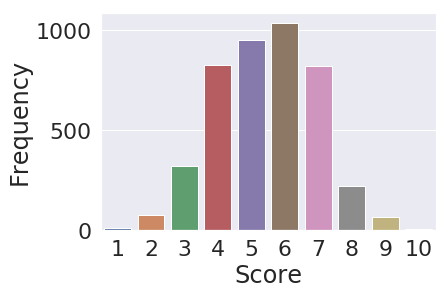

In [18]:
c = sorted(Counter(all_ratings).items())
freq = pd.DataFrame(c, columns = ['score', 'number'])
bars = sns.barplot(x='score', y='number', data=freq)
# bars.set_title('Frequency of Review Score')
bars.set_ylabel('Frequency')
bars.set_xlabel('Score')
# xlabels = bars.set_xticklabels(bars.get_xticklabels(), rotation=90)
plt.show()

In [19]:
def plot_heatmap(df):
    all_ratings = df['ratings'].agg(sum)
    all_confidence = df['confidence'].agg(sum)
    N, M = len(set(all_confidence)), len(set(all_ratings))
    heat = np.zeros((N, M))
    c = Counter(zip(all_confidence, all_ratings))
    for key in c:
        row, col = key
        heat[row-1, col-1] = c[key]
    normalized_heat = heat/np.linalg.norm(heat, axis=0)
    
    ax = sns.heatmap(normalized_heat, xticklabels=list(range(1,11)), yticklabels=list(range(1,6)), linewidths=.5)
#     ax.set_title('Confidence in Reviews. \nNormalized for each review score.')
    ax.set_xlabel('Score')
    ax.set_ylabel('Confidence')
    plt.show()
    
def plot_frequencies(df):
    topics = Counter(df.topic).most_common(50)
    topics = list(filter(lambda v: v[0], topics))
    freq = pd.DataFrame(topics, columns = ['topic', 'occurences'])
    bars = sns.barplot(x='topic', y='occurences', data=freq)
#     bars.set_title('Frequency of Popular Topics.')
    bars.set_xlabel('Topics')
    bars.set_ylabel('Submissions')
    xlabels = bars.set_xticklabels(bars.get_xticklabels(), rotation=90)
    plt.show()

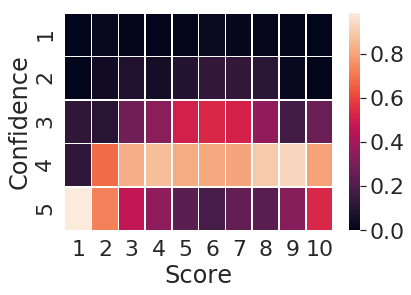

In [20]:
plot_heatmap(df)

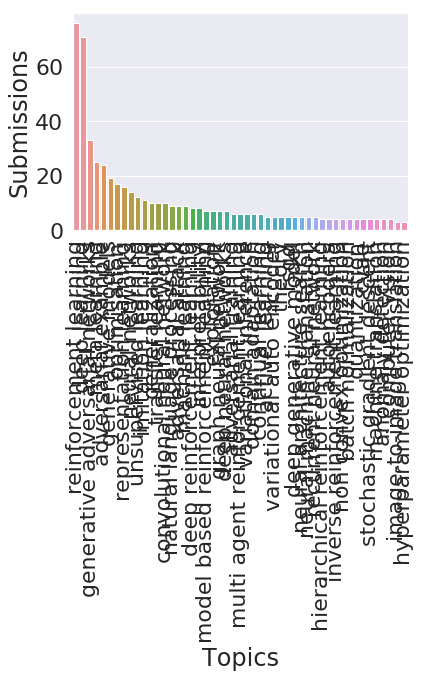

In [21]:
plot_frequencies(df)

In [22]:
col_defs = {
    name: {
        'width': 50
    } for name in ['Index', 'confidence', 'ratings']
}
col_defs['title'] = {'width': 500}
col_defs['avg_rating'] = {'width': 100}
col_defs['tldr'] = {'width': 1000}
col_defs['url'] = {'width': 300}
col_defs['topic'] = {'width': 200}
grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100}
grid = qgrid.show_grid(df, column_definitions=col_defs, grid_options = grid_options, precision=1)

In [23]:
grid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…